# MOVIE RATING ANALYSIS
<font color=lightblue>This is for DES434 project. The dataset we used is from MoviesLens, specifically the 100k dataset which can be found here https://grouplens.org/datasets/movielens/.
The dataset contains 100k movies with their genre, rating, year, user ids and timestamp.


## Import the required modules

# Group Member
<font color=lightblue>Ekpiti Kawtummachai 6322770387

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load required files
<font color=lightblue>For first time data load:
Required files will be uploaded via github

In [87]:
import io

# First time data load.
movies = pd.read_csv('https://raw.githubusercontent.com/Tenyyy/moviesproject/main/movies.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/Tenyyy/moviesproject/main/ratings.csv')

# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and years.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # change Nan years into float if theres one.
movies.title = movies.title.str[:-7]

# Split the genre ('|')
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)


ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)


userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Number of movies Null values:  13
Number of ratings Null values:  0


## Exploring the data  <br>

<font color=lightblue>The number of movies released per year and their respective ratings


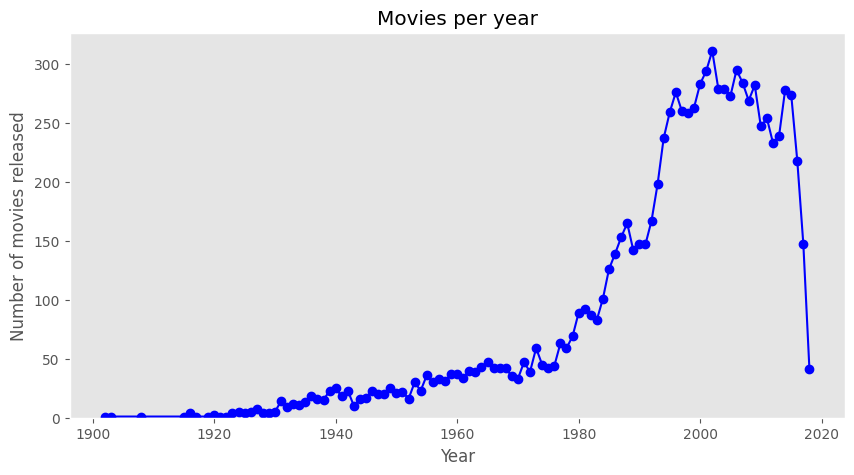

In [88]:
dataset = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dataset.year.first(), dataset.movieId.nunique(), "b-o", )
ax1.grid(None)
ax1.set_ylim(0,)


ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released')
plt.title('Movies per year')
plt.show()

%reset_selective -f (^dataset$|^ax1$|^ax2$)



# Pie chart to visualize the movie rating
<font color=lightblue> We created a new dataframe to add rating to the movies file based on their title and userid

In [89]:
merged_dataset = pd.merge(movies, ratings, how='inner', on='movieId')
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})
avg_highly_rated_movies = refined_dataset.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()

Split of movies count based on their overall average rating


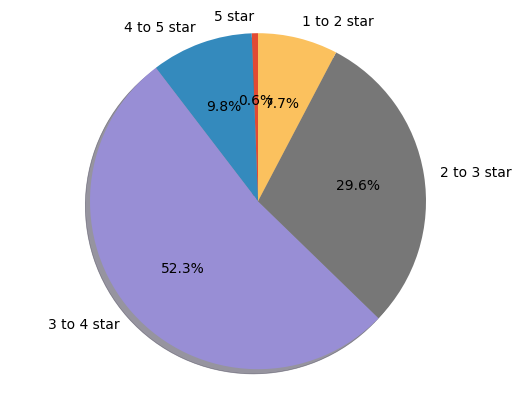

In [90]:
import matplotlib.pyplot as plt
print('Split of movies count based on their overall average rating')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '5 star', '4 to 5 star', '3 to 4 star', '2 to 3 star', '1 to 2 star'
sizes = [10, 163, 871, 492, 128]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Total number of movies and its respective genre

<Figure size 1000x500 with 0 Axes>

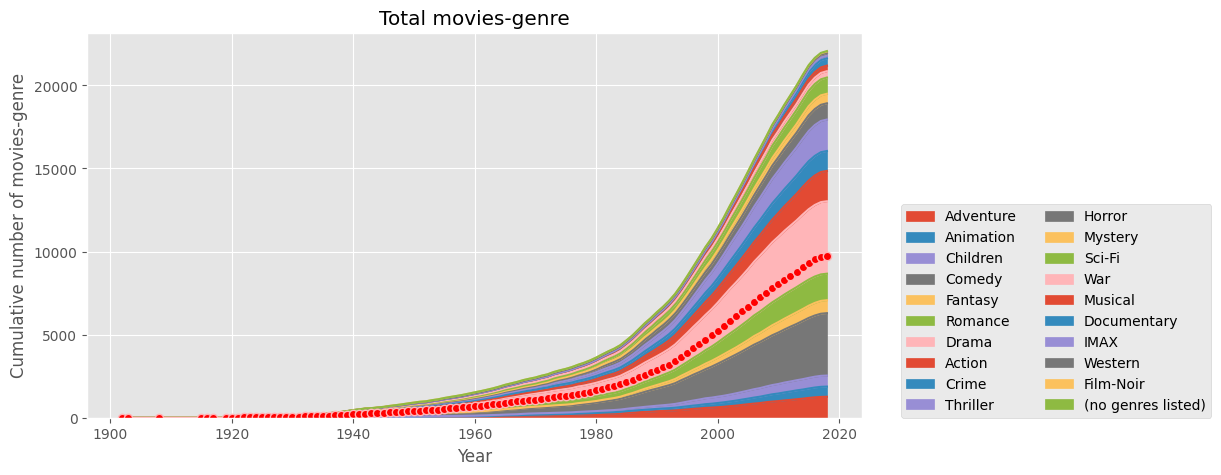

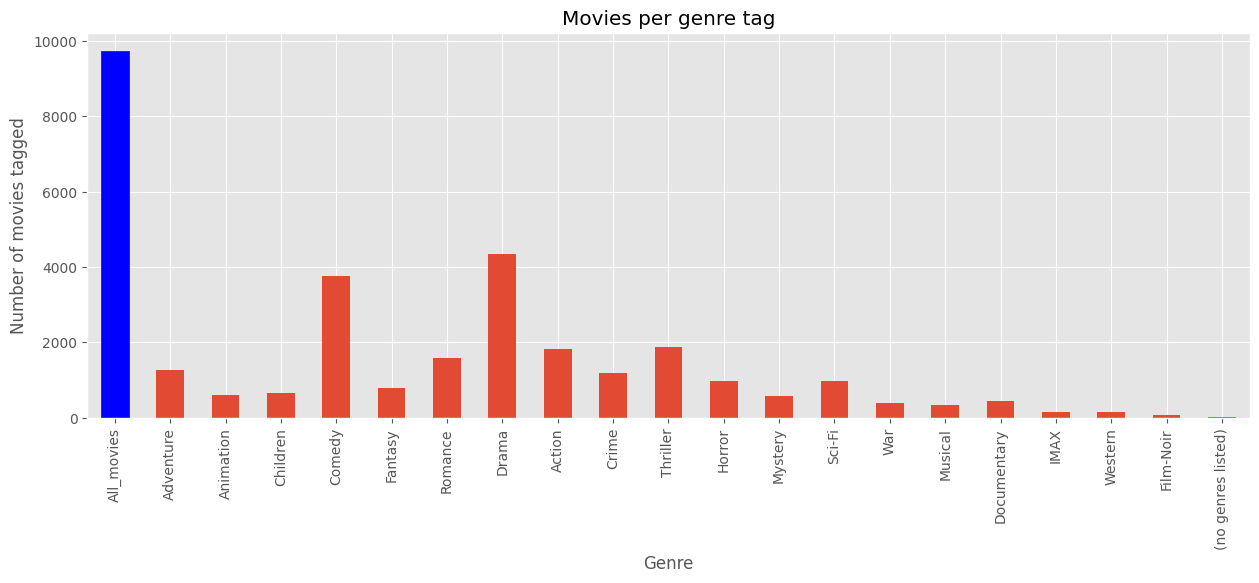

In [91]:
st = default_timer()

plt.figure(figsize=(10,5))
dataset = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dataset.movieId.nunique().cumsum()})
# Plotting the graph based on the movies
for genre in genres_unique.genre:
    dataset = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dataset.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='red')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b')
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

%reset_selective -f (^barlist$|^dataset$|^genre$)


<font color=lightblue>Note that some movies have multiple genres so the cummulative count from movies with their genre will be higher than the All_movies count

# Average rating of each movies

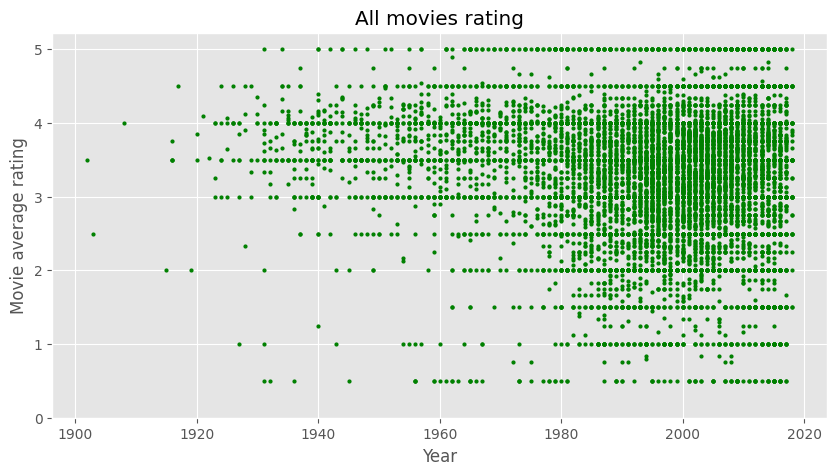

Elapsed time(sec):  0.25


In [92]:
st = default_timer()

dataset = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dataset.year, dataset.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

%reset_selective -f (^dataset$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

# Average rating for each movie and its year of release

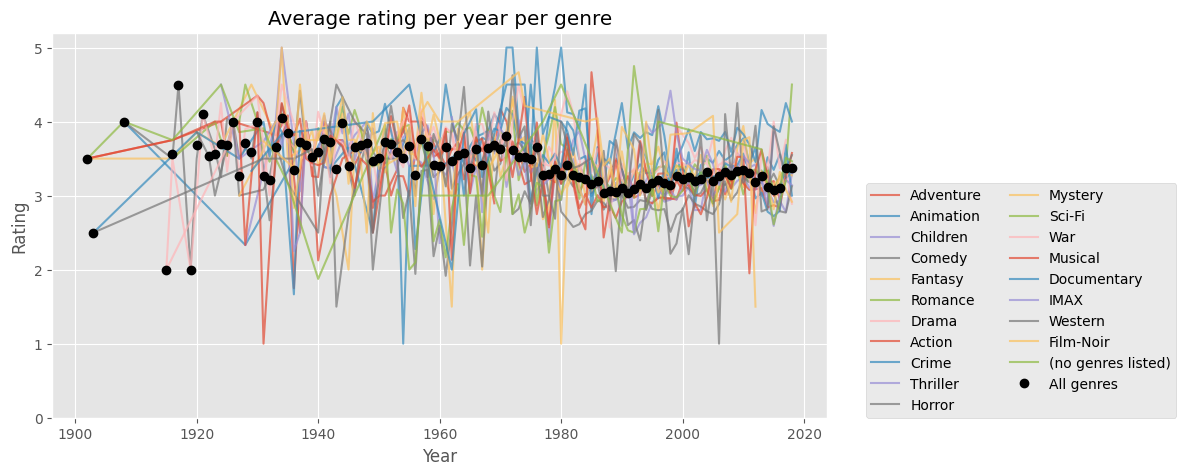

In [93]:
plt.figure(figsize=(10,5))
# For each genre
for genre in genres_unique.genre:
    dataset = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    dataset = dataset.join(ratings[ratings.set_index('movieId').index.isin(dataset.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Make new dataframe that is joined by movieid year and its rating
    dataset = dataset.groupby('year').mean()
    plt.plot(dataset, label = genre, alpha=0.7)

# All genre
dataset = movies[['movieId', 'year']].set_index('movieId')
dataset = dataset.join(ratings[ratings.set_index('movieId').index.isin(dataset.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dataset = dataset.groupby('year').mean()
plt.plot(dataset, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()


%reset_selective -f (^dataset$|^genre$)


# Rating for each users

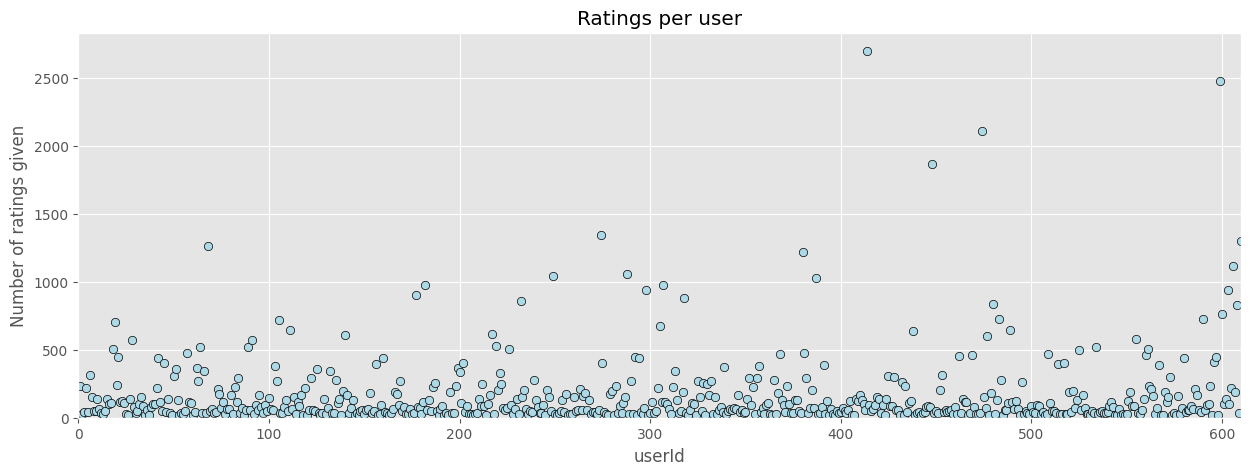

In [94]:
# Scatter plot of all users and individual ratings count.
dataset = ratings[['userId', 'movieId']].groupby('userId').count()
dataset.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dataset.index, dataset.num_ratings, edgecolor='black', color='lightblue')
plt.xlim(0,len(dataset.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()



%reset_selective -f (^dataset$)